Name: George Downing\
PI: J7526527

# TreeSat Species Classifications
# Sample notebook

This notebook shows you how to use the TreeSat dataset. It takes you through 
* loading the data into three datasets (for training, validation, and testing)
* how to create, train, save, and evaluate a sample model using this data.

You should use this notebook as the basis for your own investigations of this data. We advise you to make a copy of this notebook for each experiment you perform with this dataset.

## Performance Tips

This dataset is large, and comprises large images. Models may take a long time to train, and may fail with out-of-memory errors.

General tips:

* If you create a modified dataset, don't `cache()` that dataset: it will be too large to fit in memory.
* If you create a modified dataset and want to `shuffle()` it, do the shuffling _after_ any `batch()` operation, and use a shuffle buffer size appropriate for the number of _batches_ (not images) in the dataset.

When you are exploring possible approaches to the EMA, you may want to test the viability of an approach by running small experiments before committing to long training runs. Ways of speeding things up include:
* using only a fraction of the data (use `train_file_labels.shard()`)
* using smaller images (use `IMAGE_RESCALE`)
* increasing the `BATCH_SIZE`

If training fails with out-of-memory issues, consider:
* using smaller images (use `IMAGE_RESCALE`)
* decreasing the `BATCH_SIZE`
* using a simpler model

Finally, with long-duration timing runs, the Jupyter front end can get confused with updating progress bars and then refuse to update the front end at all. It's best to train for an epoch or two with `verbose=1` to check things are working, then redo the full training run with `verbose=0` to ensure you can see outuput in the notebook later.

## Setup

In [2]:
import tensorflow as tf
import numpy as np
import csv
import os
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, datasets, metrics, Sequential, utils
from tensorflow.keras.layers import *
from IPython.display import HTML, display
import matplotlib.pyplot as plt
%matplotlib inline

# Data format and structure

The dataset contains just over 50,000 images, each showing a 60m × 60m region of a forest in Germany. Each image shows mainly one species of tree. There are three levels of label for each image: the English name (level 3), forest management class (level 2), and leaf type (level 1).

![Treesat label levels](treesat_label_levels.png)
> Image detail from Ahlswede _et al._ (2023) figure 4.

The dataset has been split into 70% training, 10% validation, and 20% testing images.

The images are 304 × 304 pixels and encoded as four-channel PNG images. We are mis-using the PNG's alpha (transparency) channel to represent the near-IR light band in the original images.

The data resides in the `/datasets/treesat/` directory. All the images are in the `/datasets/treesat/images/` directory. There are three `.csv` files that specify which images are in which split of the dataset. There are three text files that list the different labels at each level.

In [3]:
!ls /datasets/treesat

images			level_3_vocabulary.txt	validation_file_labels.csv
level_1_vocabulary.txt	test_file_labels.csv
level_2_vocabulary.txt	train_file_labels.csv


If we look at one of the `.csv` files, we can see the image name and labels at each level.

In [4]:
!head /datasets/treesat/train_file_labels.csv

Similarly, we can see the distinct labels at each level.

In [5]:
!cat /datasets/treesat/level_2_vocabulary.txt

larch
cleared
beech
oak
douglas fir
pine
fir
short-lived deciduous
long-lived deciduous
spruce


# Defining constants

`label_level` is one of 1, 2, or 3, and is the level of labels used in this notebook.

In [6]:
data_dir = '/datasets/treesat'
label_level = 2

In [7]:
IMAGE_RESCALE = (152, 152)
input_shape = (IMAGE_RESCALE[0], IMAGE_RESCALE[1], 4)
batch_size = 128
label_key = f'level_{label_level}'

# Loading data

First, we load the image names and labels into the `file_label` datasets. 

In [8]:
train_file_labels = tf.data.experimental.make_csv_dataset(
    os.path.join(data_dir, 'train_file_labels.csv'), batch_size=batch_size, num_epochs=1)
train_file_labels = train_file_labels.unbatch()

In [9]:
validation_file_labels = tf.data.experimental.make_csv_dataset(
    os.path.join(data_dir, 'validation_file_labels.csv'), 
    batch_size=batch_size, num_epochs=1,
    shuffle=False)
validation_file_labels = validation_file_labels.unbatch()

In [10]:
test_file_labels = tf.data.experimental.make_csv_dataset(
    os.path.join(data_dir, 'test_file_labels.csv'), 
    batch_size=batch_size, num_epochs=1,
    shuffle=False)
test_file_labels = test_file_labels.unbatch()

We load the vocabulary for this level of labels and create a `StringLookup` encoder that will convert each label into a one-hot vector.

In [11]:
encoder_vocab_file = os.path.join(data_dir, f'level_{label_level}_vocabulary.txt')
label_encoder = StringLookup(vocabulary=encoder_vocab_file, num_oov_indices=0, output_mode='one_hot')

num_classes = len(label_encoder.get_vocabulary())

label_lookup = {i: n for i, n in enumerate(label_encoder.get_vocabulary())}
label_lookup

{0: 'larch',
 1: 'cleared',
 2: 'beech',
 3: 'oak',
 4: 'douglas fir',
 5: 'pine',
 6: 'fir',
 7: 'short-lived deciduous',
 8: 'long-lived deciduous',
 9: 'spruce'}

With the labels defined, we know enough to pretty-print a confusion matrix.

In [12]:
def pretty_cm(cm):
    result_table  = '<h3>Confusion matrix</h3>\n'
    result_table += '<table border=1>\n'
    result_table += f'<tr><td>&nbsp;</td><td>&nbsp;</td><th colspan={len(label_lookup)}>Predicted labels</th></tr>\n'
    result_table += '<tr><td>&nbsp;</td><td>&nbsp;</td>'

    for _, cn in sorted(label_lookup.items()):
        result_table += f'<td><strong>{cn}</strong></td>'
    result_table += '</tr>\n'

    result_table += '<tr>\n'
    result_table += f'<th rowspan={len(label_lookup) + 1}>Actual labels</th>\n'

    for ai, an in sorted(label_lookup.items()):
        result_table += '<tr>\n'
        result_table += f'  <td><strong>{an}</strong></td>\n'
        for pi, pn in sorted(label_lookup.items()):
            result_table += f'  <td>{cm[ai, pi]}</td>\n'
        result_table += '</tr>\n'
    result_table += "</table>"
    # print(result_table)
    display(HTML(result_table))

We have a function that take a filename and text label and returns the image and one-hot encoded label.

In [13]:
# Adjusted load_image function to accept file_path and label separately
def load_image(file_path, label):
    # read the image from disk, decode it, resize it, and scale the pixels intensities to the range [0, 1]
    image = tf.io.read_file(file_path)
    image = tf.io.decode_png(image, channels=4)
    image = tf.image.resize(image, IMAGE_RESCALE)
    image /= 255.0
    
    # grab the label and encode it
    encoded_label = label_encoder(label)
    
    # return the image and the one-hot encoded label
    return image, encoded_label

## Loading the images

Now we can load the images into datasets.

In [14]:
train_data = train_file_labels.map(lambda fl: (fl['file_name'], fl[label_key]), 
                                      num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(200)
train_data = train_data.map(load_image, 
                                      num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

In [15]:
validation_data = validation_file_labels.map(lambda fl: (fl['file_name'], fl[label_key]), 
                                      num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.map(load_image, 
                                      num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

In [16]:
test_data = test_file_labels.map(lambda fl: (fl['file_name'], fl[label_key]), 
                                      num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(load_image, 
                                      num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

# Exploring the data

We can now explore some elements of the data, such as some sample images and the distribution of classes.

## Distribution of classes

In [16]:
class_counts = train_file_labels.map(lambda fl: label_encoder(fl[label_key]))
class_counts = class_counts.reduce(tf.zeros((num_classes,)),
                             lambda o, l: tf.math.add(o, l))
class_counts

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([2145., 2844., 4508., 5515., 1896., 5324.,  687., 4131., 4118.,
       4098.], dtype=float32)>

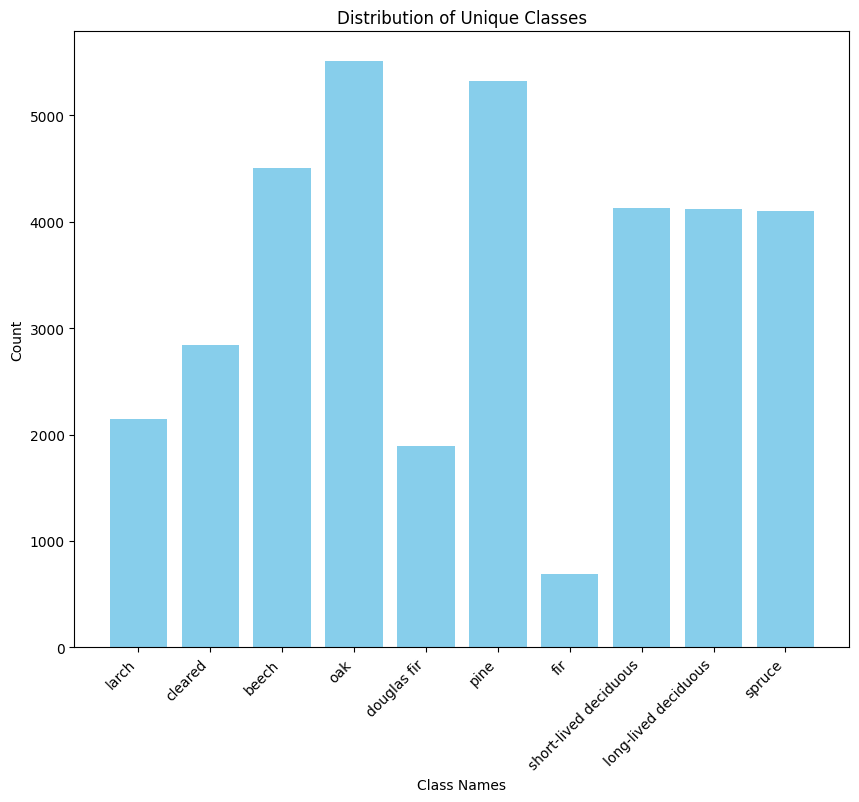

In [17]:
# Plot distribution using class names
plt.figure(figsize=(10, 8))
plt.bar(label_encoder.get_vocabulary(), class_counts.numpy(), color='skyblue')
plt.xlabel("Class Names")
plt.ylabel("Count")
plt.title("Distribution of Unique Classes")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()  # Display the plotted distribution

## Show some sample images

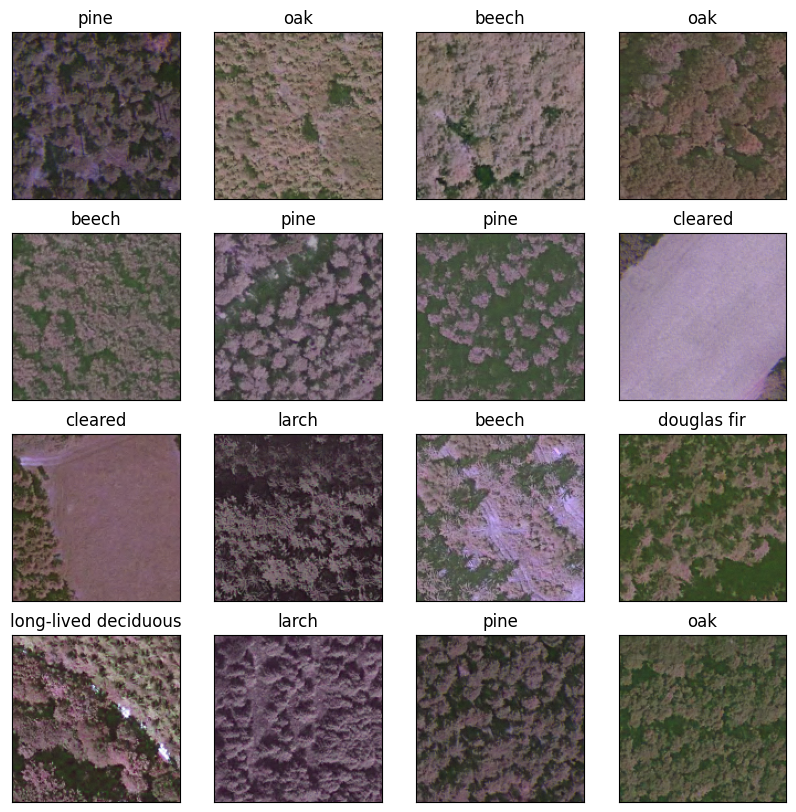

In [18]:
sample_images, sample_labels = train_data.as_numpy_iterator().next()

plt.figure(figsize=(10, 10))
for i in range(16):  # Adjust this number based on how many images you want to display
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(sample_images[i, ..., :-1]) # drop the alpha channel, to make the images more like you'd see
#     plt.imshow(sample_images[i]) # image with alpha channel
    label_index = np.argmax(sample_labels[i])
    class_name = label_lookup[label_index]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(class_name)

# Create and train a sample model

This is a a trivial model just to demonstrate the use of the datasets. 

In [19]:
model_sample = Sequential([
    Conv2D(8, (5, 5), padding='same', activation='relu', input_shape=input_shape),
    Conv2D(8, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
   
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_sample.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 304, 304, 8)       808       
                                                                 
 conv2d_1 (Conv2D)           (None, 304, 304, 8)       1608      
                                                                 
 max_pooling2d (MaxPooling2  (None, 76, 76, 8)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 46208)             0         
                                                                 
 dense (Dense)               (None, 128)               5914752   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

In [20]:
model_sample.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
history = model_sample.fit(
    train_data,
    epochs=5,
    validation_data=validation_data
)

Epoch 1/5
276/276 [==============================] - 91s 304ms/step - loss: 2.0517 - accuracy: 0.2527 - val_loss: 1.8656 - val_accuracy: 0.3239
Epoch 2/5
276/276 [==============================] - 81s 294ms/step - loss: 1.7524 - accuracy: 0.3721 - val_loss: 1.9021 - val_accuracy: 0.3235
Epoch 3/5
276/276 [==============================] - 81s 293ms/step - loss: 1.5518 - accuracy: 0.4554 - val_loss: 1.6601 - val_accuracy: 0.4095
Epoch 4/5
276/276 [==============================] - 81s 293ms/step - loss: 1.2776 - accuracy: 0.5640 - val_loss: 1.6943 - val_accuracy: 0.4109
Epoch 5/5
276/276 [==============================] - 81s 293ms/step - loss: 0.9609 - accuracy: 0.6812 - val_loss: 1.9728 - val_accuracy: 0.3724


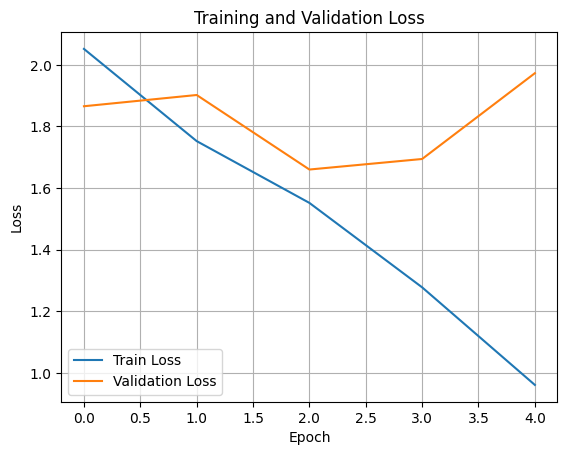

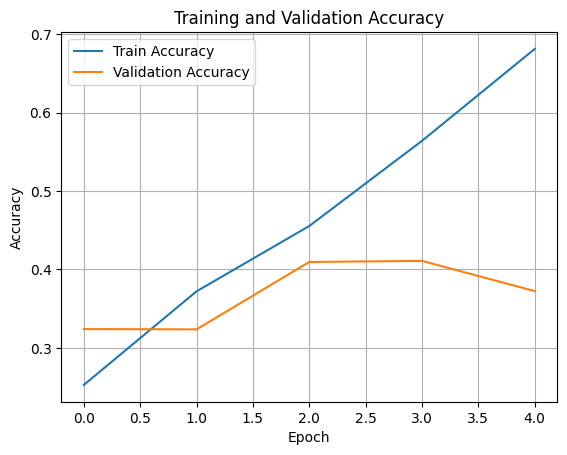

In [22]:
import matplotlib.pyplot as plt

# Assuming history contains the training history returned by model.fit
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Cache results for later

In [23]:
model_sample.save('example_model.keras')

with open('example_model_history.json', 'w') as f:
    json.dump(history.history, f)

In [24]:
model_sample = tf.keras.models.load_model('example_model.keras')

with open('example_model_history.json') as f:
    example_history = json.load(f)

## Evaluating the model

In [27]:
model_sample.evaluate(test_data, return_dict=True)

79/79 [==============================] - 19s 240ms/step - loss: 1.9814 - accuracy: 0.3816


{'loss': 1.9814265966415405, 'accuracy': 0.3815619647502899}

In [28]:
test_predictions = model_sample.predict(test_data)

79/79 [==============================] - 16s 202ms/step


In [29]:
predict_labels = np.argmax(test_predictions, axis=1)

In [30]:
test_labels = np.array(list(test_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_labels = np.argmax(test_labels, axis=1)

In [31]:
cm = tf.math.confusion_matrix(test_labels, predict_labels).numpy()
pretty_cm(cm)

# My Work

## Weighting Data

An approach to combating the imbalanced data is to give weights to data examples, indicating how much attention the learning process should pay to them. This will be done by dividing the number of examples by the number of examples of this class, scaling by the number of classes, which is 10 since we are using level 2 labels. We have changed the image rescale from (304,304) to (152,152) to help avoid issues with running out of memory when training.

In [16]:
class_counts = train_data.unbatch().reduce(tf.zeros((10,)),
                             lambda o, il: tf.math.add(o, il[1])).numpy()
class_counts

array([2145., 2844., 4508., 5515., 1896., 5324.,  687., 4131., 4118.,
       4098.], dtype=float32)

In [17]:
all_train_size = sum(class_counts)
all_train_size

35266.0

In [18]:
class_weights = tf.constant([all_train_size / (10 * cc) for cc in class_counts])
class_weights

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([1.64410256, 1.24001406, 0.78229814, 0.63945603, 1.8600211 ,
       0.66239669, 5.13333333, 0.8536916 , 0.8563866 , 0.86056613])>

Now that we have calculated the weights for each class, we can provide weights in the training dataset by having each element of the dataset be a 3-tuple.

In [19]:
def add_weight(image, one_hot_label):
    label = tf.argmax(one_hot_label)
    return image, one_hot_label, class_weights[label]

In [20]:
weighted_train_data = train_data.unbatch().map(add_weight)
weighted_train_data

<_MapDataset element_spec=(TensorSpec(shape=(152, 152, 4), dtype=tf.float32, name=None), TensorSpec(shape=(10,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>

Finally we will batch and then shuffle the data.

In [21]:
weighted_train_data = weighted_train_data.shuffle(all_train_size)
weighted_train_data = weighted_train_data.batch(batch_size)
weighted_train_data = weighted_train_data.prefetch(tf.data.AUTOTUNE)
weighted_train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 152, 152, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

Now the training data has weights, we can move onto creating models. Before doing that we will delete the training dataset as it is no longer needed, and it will free up memory for training the models.

In [ ]:
import gc
del train_data
gc.collect()

## Baseline Model (model_0)

I will start by creating a baseline model to compare the performance of any future changes to. The model will have 4 convolution layers, all with a ReLU activation. After each set of 2 convolution layers there will be a max pooling layer. There will also be one dropout layer to try and help avoid overfitting. All the layers will use a ReLU activation, except for the final Dense layer which will use a softmax.

In [22]:
model_0 = Sequential([
    Conv2D(8, (5, 5), padding='same', activation='relu', input_shape=input_shape),
    Conv2D(8, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Conv2D(4, (5, 5), padding='same', activation='relu'),
    Conv2D(4, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Dropout(rate=0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 152, 152, 8)       808       
                                                                 
 conv2d_1 (Conv2D)           (None, 152, 152, 8)       1608      
                                                                 
 max_pooling2d (MaxPooling2  (None, 38, 38, 8)         0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 4)         804       
                                                                 
 conv2d_3 (Conv2D)           (None, 38, 38, 4)         404       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 9, 4)           0         
 g2D)                                                   

The model will be compiled using the code below, using categorical cross entropy as it's loss function, and with an adam optimizer.

In [23]:
model_0.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])
model_0.optimizer.get_config()

{'name': 'Adam',
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'jit_compile': True,
 'is_legacy_optimizer': False,
 'learning_rate': 0.001,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

Then we will train the model on the weighted training data with the code below for 20 epochs, before saving the model so it can be accessed later.

In [24]:
model_0_history = model_0.fit(
    weighted_train_data,
    epochs=25,
    validation_data=validation_data,
    verbose=0)

model_0.save('model_0_review_25.keras')
with open('model_0_review_history_25.json', 'w') as f:
    json.dump(model_0_history.history, f)

2024-05-23 08:06:20.316184: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Next I will reload the model and it's history with the code below.

In [17]:
model_0 = tf.keras.models.load_model('model_0_review_25.keras')
with open('model_0_review_history_25.json') as f:
    model_0_history = json.load(f)

Next the code below will plot the training and validation accuracies and losses to see what we can notice from them.

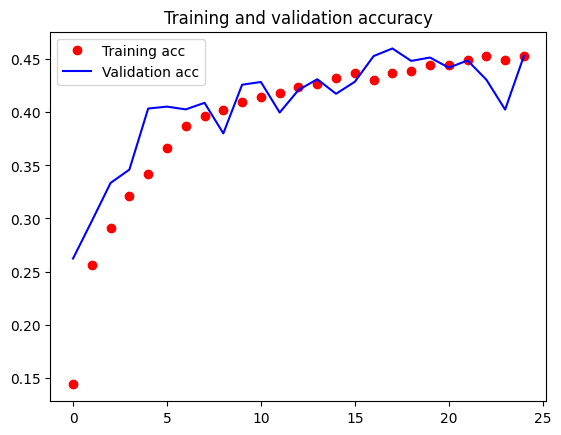

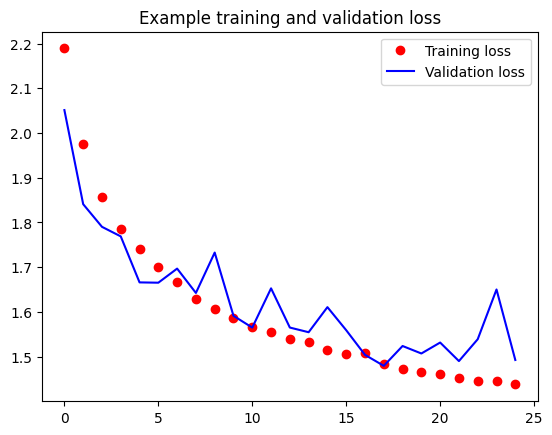

In [27]:
acc = model_0_history['accuracy']
val_acc = model_0_history['val_accuracy']
loss = model_0_history['loss']
val_loss = model_0_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Example training and validation loss')
plt.legend()

plt.show()

From this we can see that both validation and accuracy have decreased for both training and validation data over the training period. Throughout the training the results from the validation data and the training data are reasonably similar which suggests that the model is not overfitting. The model is still improving at the end of the training period, even though the rate of improvement is decreasing, suggesting that the model may benefit from further training. However, the loss for training and validation appear to be separating so more training may lead to overfitting.

Finally we will evaluate the model using the series of code below.

In [28]:
model_0.evaluate(test_data, return_dict=True)

79/79 [==============================] - 19s 234ms/step - loss: 1.4691 - accuracy: 0.4566


{'loss': 1.4691014289855957, 'accuracy': 0.45658430457115173}

In [18]:
test_predictions_0 = model_0.predict(test_data)

79/79 [==============================] - 20s 233ms/step


In [19]:
predict_labels_0 = np.argmax(test_predictions_0, axis=1)

In [20]:
test_labels = np.array(list(test_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_labels = np.argmax(test_labels, axis=1)

In [21]:
cm_0 = tf.math.confusion_matrix(test_labels, predict_labels_0).numpy()
pretty_cm(cm_0)

I will use the code below to calculate the average precision and recall of the model. The code goes through each row to find the number of true positives, false negatives, false positives and true negatives for each class, before adding this to a list and showing the average of them.

In [23]:
precision = []
recall = []

    TP = cm_0[i, i]
    
    FN = np.sum(cm_0[i, :]) - TP
    
    FP = np.sum(cm_0[:, i]) - TP
    
    TN = np.sum(cm_0) - (TP + FN + FP)
    
    precision_i = TP / (TP + FP) if (TP + FP) != 0 else 0
    precision.append(precision_i)
    
    recall_i = TP / (TP + FN) if (TP + FN) != 0 else 0
    recall.append(recall_i)

average_precision = np.mean(precision)
average_recall = np.mean(recall)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Precision: 0.42570612441068134
Average Recall: 0.46797315920782534


The model has an accuracy of 46% when evaluated on the test data. We can see from the confusion matrix that the rows for deciduous trees seem to be more spread out suggesting the model is struggling to classify these trees. The model had a precision of 43% and a recall of 47%.

## Additional Filters (model_filter)

One change that could enhance the performance of the model would be to increase the number of filters in each layer. This would result in more feature maps in each layer which may improve performance. To test this we will make a model in the same form as the baseline model, but with quadruple the number of filters in each convolution layer.

In [33]:
model_filter = Sequential([
    Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=input_shape),
    Conv2D(32, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Conv2D(16, (5, 5), padding='same', activation='relu'),
    Conv2D(16, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Dropout(rate=0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model_filter.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 152, 152, 32)      3232      
                                                                 
 conv2d_5 (Conv2D)           (None, 152, 152, 32)      25632     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 38, 38, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 38, 38, 16)        12816     
                                                                 
 conv2d_7 (Conv2D)           (None, 38, 38, 16)        6416      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 9, 9, 16)          0         
 g2D)                                                 

The model will be compiled using the code below, using categorical cross entropy as it's loss function, and with an adam optimizer. Then we will train the model on the weighted training data with the code below for 20 epochs, before saving the model so it can be accessed later.

In [34]:
model_filter.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

model_filter_history = model_filter.fit(
    weighted_train_data,
    epochs=25,
    validation_data=validation_data,
    verbose=0)

2024-05-23 08:42:21.451732: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


In [35]:
model_filter.save('model_filter_review_25.keras')
with open('model_filter_review_history_25.json', 'w') as f:
    json.dump(model_filter_history.history, f)

Next I will reload the model and it's history with the code below.

In [24]:
model_filter = tf.keras.models.load_model('model_filter_review_25.keras')
with open('model_filter_review_history_25.json') as f:
    model_filter_history = json.load(f)

Next the code below will plot the training and validation accuracies and losses to see what we can notice from them.

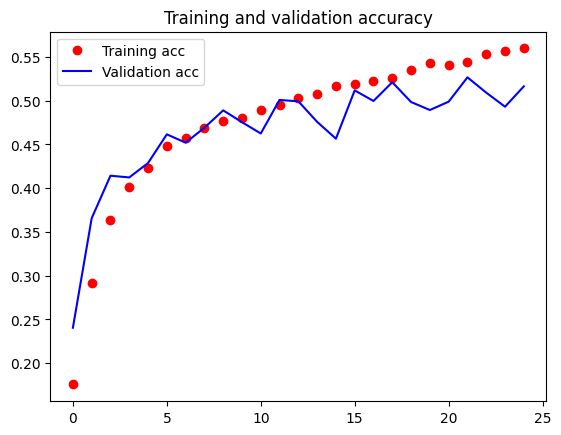

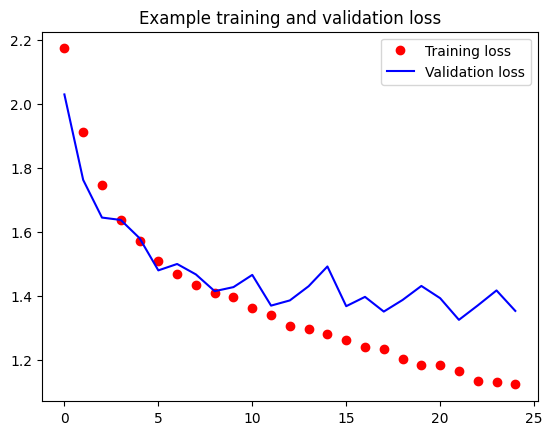

In [37]:
acc = model_filter_history['accuracy']
val_acc = model_filter_history['val_accuracy']
loss = model_filter_history['loss']
val_loss = model_filter_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Example training and validation loss')
plt.legend()

plt.show()

From this we can see that both validation and accuracy have decreased for both training and validation data over the training period. The model is still improving at the end of the training period, even though the rate of improvement is decreasing, suggesting that the model may benefit from further training. However, the loss for training and validation have been separating since around the 10th epoch, so additional training is likely to lead to overfitting.

Finally we will evaluate the model on the test data and create a confusion matrix using the series of code below.

In [38]:
model_filter.evaluate(test_data, return_dict=True)

79/79 [==============================] - 19s 241ms/step - loss: 1.3475 - accuracy: 0.5174


{'loss': 1.3475275039672852, 'accuracy': 0.5174158811569214}

In [25]:
test_predictions_filter = model_filter.predict(test_data)

79/79 [==============================] - 22s 249ms/step


In [26]:
predict_labels_filter = np.argmax(test_predictions_filter, axis=1)

In [27]:
cm_filter = tf.math.confusion_matrix(test_labels, predict_labels_filter).numpy()
pretty_cm(cm_filter)

I will use the code below to calculate the average precision and recall of the model. The code goes through each row to find the number of true positives, false negatives, false positives and true negatives for each class, before adding this to a list and showing the average of them.

In [28]:
precision = []
recall = []

for i in range(num_classes):
    TP = cm_filter[i, i]
    
    FN = np.sum(cm_filter[i, :]) - TP
    
    FP = np.sum(cm_filter[:, i]) - TP
    
    TN = np.sum(cm_filter) - (TP + FN + FP)
    
    precision_i = TP / (TP + FP) if (TP + FP) != 0 else 0
    precision.append(precision_i)
    
    recall_i = TP / (TP + FN) if (TP + FN) != 0 else 0
    recall.append(recall_i)

average_precision = np.mean(precision)
average_recall = np.mean(recall)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Precision: 0.4836180969180396
Average Recall: 0.5160422810262584


The model has an accuracy of 52% when evaluated on the test data. Similarly to the baseline model, we can see from the confusion matrix that the rows for deciduous trees seem to be more spread out suggesting the model is struggling to classify these trees. The model had a precision of 48% and a recall of 52%.

## Adding Convolution Layers (model_layers)

Another method for improving the performance of the model could be to add more convolution layers to the model. This could result improve the performance as it will allow the model to look at more representations of the images. To achieve this we will add two more convolution layers with 4 filters between the two max pooling layers.

In [42]:
model_layers = Sequential([
    Conv2D(8, (5, 5), padding='same', activation='relu', input_shape=input_shape),
    Conv2D(8, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Conv2D(4, (5, 5), padding='same', activation='relu'),
    Conv2D(4, (5, 5), padding='same', activation='relu'),
    Conv2D(4, (5, 5), padding='same', activation='relu'),
    Conv2D(4, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Dropout(rate=0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

The model will be compiled using the code below, using categorical cross entropy as it's loss function, and with an adam optimizer. Then we will train the model on the weighted training data with the code below for 20 epochs, before saving the model so it can be accessed later.

In [43]:
model_layers.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

model_layers_history = model_layers.fit(
    weighted_train_data,
    epochs=25,
    validation_data=validation_data,
    verbose=0)

2024-05-23 09:16:09.436414: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


In [44]:
model_layers.save('model_layers_review_25.keras')
with open('model_layers_review_history_25.json', 'w') as f:
    json.dump(model_layers_history.history, f)

Next I will reload the model and it's history with the code below.

In [29]:
model_layers = tf.keras.models.load_model('model_layers_review_25.keras')
with open('model_layers_review_history_25.json') as f:
    model_layers_history = json.load(f)

Next the code below will plot the training and validation accuracies and losses to see what we can notice from them.

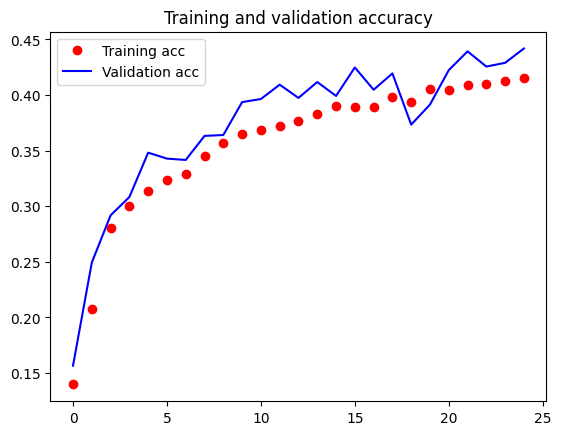

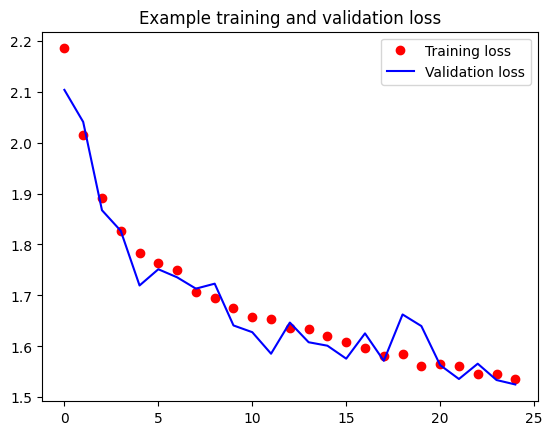

In [46]:
acc = model_layers_history['accuracy']
val_acc = model_layers_history['val_accuracy']
loss = model_layers_history['loss']
val_loss = model_layers_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Example training and validation loss')
plt.legend()

plt.show()

From this we can see that both validation and accuracy have decreased for both training and validation data over the training period. Throughout the training the results from the validation data and the training data are reasonably similar which suggests that the model is not overfitting. The model is still improving at the end of the training period, even though the rate of improvement is decreasing, suggesting that the model may benefit from further training.

Finally we will evaluate the model on the test data and create a confusion matrix using the series of code below.

In [47]:
model_layers.evaluate(test_data, return_dict=True)

79/79 [==============================] - 18s 221ms/step - loss: 1.5122 - accuracy: 0.4447


{'loss': 1.5122286081314087, 'accuracy': 0.4446759819984436}

In [30]:
test_predictions_layers = model_layers.predict(test_data)

79/79 [==============================] - 19s 233ms/step


In [31]:
predict_labels_layers = np.argmax(test_predictions_layers, axis=1)

In [34]:
cm_layers = tf.math.confusion_matrix(test_labels, predict_labels_layers).numpy()
pretty_cm(cm_layers)

I will use the code below to calculate the average precision and recall of the model. The code goes through each row to find the number of true positives, false negatives, false positives and true negatives for each class, before adding this to a list and showing the average of them.

In [35]:
precision = []
recall = []

for i in range(num_classes):
    TP = cm_layers[i, i]
    
    FN = np.sum(cm_layers[i, :]) - TP
    
    FP = np.sum(cm_layers[:, i]) - TP
    
    TN = np.sum(cm_layers) - (TP + FN + FP)
    
    precision_i = TP / (TP + FP) if (TP + FP) != 0 else 0
    precision.append(precision_i)
    
    recall_i = TP / (TP + FN) if (TP + FN) != 0 else 0
    recall.append(recall_i)

average_precision = np.mean(precision)
average_recall = np.mean(recall)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Precision: 0.41348402504230747
Average Recall: 0.43199214001089137


The model has an accuracy of 44% when evaluated on the test data. Once again, we can see from the confusion matrix that the rows for deciduous trees seem to be more spread out suggesting the model is struggling to classify these trees. The model had a precision of 41% and a recall of 43%.

## Changing Learning Rate (model_lr)

We could also improve the performance of the model by increasing the learning rate. This will allow for faster convergence meaning the model is more likely to find its optimal in the training. We saw previously that the Adam optimizer has a learning rate of 0.001, so we will experiment with a learning rate of 0.01. The first step is to build a model in the same format as the baseline model using the code below.

In [51]:
model_lr = Sequential([
    Conv2D(8, (5, 5), padding='same', activation='relu', input_shape=input_shape),
    Conv2D(8, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Conv2D(4, (5, 5), padding='same', activation='relu'),
    Conv2D(4, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Dropout(rate=0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model_lr.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 152, 152, 8)       808       
                                                                 
 conv2d_15 (Conv2D)          (None, 152, 152, 8)       1608      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 38, 38, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 38, 38, 4)         804       
                                                                 
 conv2d_17 (Conv2D)          (None, 38, 38, 4)         404       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 9, 9, 4)           0         
 g2D)                                                 

We can then use the code below to create a new optimizer in the same form as the adam optimizer, but with the learning rate changed to 0.01

In [52]:
opt = optimizers.Adam(learning_rate=0.01)
opt.get_config()

{'name': 'Adam',
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'jit_compile': True,
 'is_legacy_optimizer': False,
 'learning_rate': 0.01,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

The model will be compiled using the code below, using categorical cross entropy as it's loss function, and with the newly created optimizer. Then we will train the model on the weighted training data with the code below for 20 epochs, before saving the model so it can be accessed later.

In [53]:
model_lr.compile(loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])

model_lr_history = model_lr.fit(
    weighted_train_data,
    epochs=25,
    validation_data=validation_data,
    verbose=0)

2024-05-23 09:45:42.238392: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


In [54]:
model_lr.save('model_lr_review_25.keras')
with open('model_lr_review_history_25.json', 'w') as f:
    json.dump(model_lr_history.history, f)

Next I will reload the model and it's history with the code below.

In [36]:
model_lr = tf.keras.models.load_model('model_lr_review_25.keras')
with open('model_lr_review_history_25.json') as f:
    model_lr_history = json.load(f)

Next the code below will plot the training and validation accuracies and losses to see what we can notice from them.

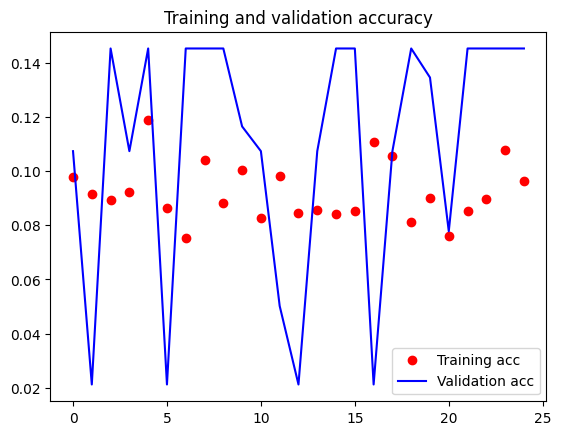

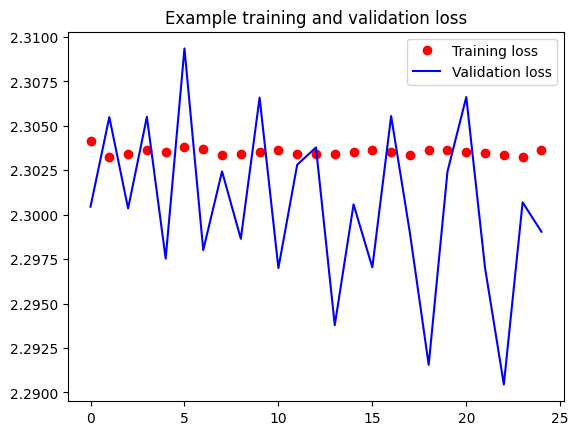

In [56]:
acc = model_lr_history['accuracy']
val_acc = model_lr_history['val_accuracy']
loss = model_lr_history['loss']
val_loss = model_lr_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Example training and validation loss')
plt.legend()

plt.show()

From this we can see that both validation and accuracy have remained the same for both training and validation data over the training period. Throughout the training the results from the validation data and the training data appear to oscillate around the same values, suggesting that the model is overshooting the optimal rates and getting stuck  at non optimal points.

Finally we will evaluate the model on the test data and create a confusion matrix using the series of code below.

In [57]:
model_lr.evaluate(test_data, return_dict=True)

79/79 [==============================] - 18s 228ms/step - loss: 2.2986 - accuracy: 0.1445


{'loss': 2.2986128330230713, 'accuracy': 0.1444874405860901}

In [37]:
test_predictions_lr = model_lr.predict(test_data)

79/79 [==============================] - 19s 236ms/step


In [38]:
predict_labels_lr = np.argmax(test_predictions_lr, axis=1)

In [40]:
cm_lr = tf.math.confusion_matrix(test_labels, predict_labels_lr).numpy()
pretty_cm(cm_lr)

I will use the code below to calculate the average precision and recall of the model. The code goes through each row to find the number of true positives, false negatives, false positives and true negatives for each class, before adding this to a list and showing the average of them.

In [41]:
precision = []
recall = []

for i in range(num_classes):
    TP = cm_lr[i, i]
    
    FN = np.sum(cm_lr[i, :]) - TP
    
    FP = np.sum(cm_lr[:, i]) - TP
    
    TN = np.sum(cm_lr) - (TP + FN + FP)
    
    precision_i = TP / (TP + FP) if (TP + FP) != 0 else 0
    precision.append(precision_i)
    
    recall_i = TP / (TP + FN) if (TP + FN) != 0 else 0
    recall.append(recall_i)

average_precision = np.mean(precision)
average_recall = np.mean(recall)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Precision: 0.01444874466607125
Average Recall: 0.1


The model has an accuracy of 14% when evaluated on the test data. We can see from the confusion matrix that the model is only predicting pine trees, suggesting this is what the model has reached. This lines up with the accuracy being 14% as roughly 1/7 trees are pine trees. The model had a precision of 1% and a recall of 10%.